In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

In [2]:
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (13, 3)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
sns.set_style('darkgrid');

In [3]:
data = pd.read_csv("car_data_cleaned.csv")

In [4]:
data.head()

,car_company,variant,car_age,km_driven,fuel_type,seller_type,transmission_type,num_of_ownership,mileage,engine,max_power,num_of_seats,selling_price
0,Maruti,Swift Dzire VDI,7,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,5,450000
1,Skoda,Others,7,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,5,370000
2,Honda,City 2017-2020 EXi,15,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,5,158000
3,Hyundai,Others,11,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,5,225000
4,Maruti,Others,14,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,5,130000


### Creating Train set and Test set

In [5]:
# Random Sampling

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size = 0.2, random_state = 42)

### Preparing the data for Machine Learning Algorithm

In [6]:
car_label = train_set['selling_price'].copy()
car_features = train_set.drop('selling_price', axis = 1)

In [7]:
car_features_category = car_features[['car_company', 'variant', 'fuel_type', 'seller_type', 'transmission_type', 'num_of_ownership']]
car_features_category.head()

,car_company,variant,fuel_type,seller_type,transmission_type,num_of_ownership
751,Mahindra,Others,Diesel,Individual,Manual,First Owner
5790,Maruti,Others,LPG,Individual,Manual,First Owner
1608,Maruti,Ertiga VXI,Petrol,Individual,Manual,First Owner
4028,Maruti,Others,Petrol,Individual,Manual,First Owner
2210,Honda,City 2017-2020 GXi,Petrol,Individual,Manual,Second Owner


In [8]:
car_features_num = car_features.drop(['car_company', 'variant', 'fuel_type', 'seller_type', 'transmission_type', 'num_of_ownership'], axis = 1)
car_features_num.head()

,car_age,km_driven,mileage,engine,max_power,num_of_seats
751,5,50000,16.00,1997,140.0,7
5790,9,60000,26.20,998,58.2,5
1608,8,140000,16.02,1373,93.7,7
4028,4,25000,21.63,998,67.0,5
2210,15,70000,17.70,1497,78.0,5


In [9]:
# Using Column Transformer to create a pipeline to use StandardScaler to perform feature scaling on num features
# and also converting categorical features into numerical feature using OneHot Encoder 

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(car_features_num)
cat_attribs = ['car_company', 'variant', 'fuel_type', 'seller_type', 'transmission_type', 'num_of_ownership']

pipeline = ColumnTransformer([
    ('std_scaler', StandardScaler(), num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

data_prepared = pipeline.fit_transform(car_features)

In [10]:
data_prepared

<5952x347 sparse matrix of type '<class 'numpy.float64'>'
	with 71424 stored elements in Compressed Sparse Row format>

In [11]:
# data size after OneHot Encoding 

data_prepared.shape

(5952, 347)

### Select and Train a Model

In [12]:
# Multiple Linear Regression

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(data_prepared, car_label)

LinearRegression()

In [13]:
# Using k-fold cross validation for checking the performance of the linear regression model using r² metric

from sklearn.model_selection import cross_val_score

lin_score = cross_val_score(lin_reg, data_prepared, car_label, scoring='r2', cv = 10).mean()
lin_score

0.8796166647512369

In [14]:
# Decision Tree Regression

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(data_prepared, car_label)

DecisionTreeRegressor()

In [15]:
# Using k-fold cross validation for checking the performance of the Decision Tree regression model using r² metric

tree_score = cross_val_score(tree_reg, data_prepared, car_label, scoring = 'r2', cv = 10).mean()
tree_score

0.8810256295669847

In [16]:
# Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(data_prepared, car_label)


RandomForestRegressor(n_estimators=10, random_state=42)

In [17]:
# Using k-fold cross validation for checking the performance of the Random Forest regression model using r² metric

forest_score = cross_val_score(forest_reg, data_prepared, car_label, scoring = 'r2', cv = 10).mean()
forest_score

0.9296695026425832

In [18]:
# SVR using linear kernel

from sklearn.svm import SVR

svm_linear_reg = SVR(kernel = 'linear')
svm_linear_reg.fit(data_prepared, car_label)


SVR(kernel='linear')

In [19]:
# Using k-fold cross validation for checking the performance of the model using r² metric

svm_lin_score = cross_val_score(svm_linear_reg, data_prepared, car_label, scoring = 'r2', cv = 10).mean()
svm_lin_score

-0.01543225132344076

As from the above results we can see that Random Forest Regression Model gives the best score on K-Fold cross validation using r² metric. Therefore, Random Forest Regression model will be used to predict the prices

### Hyperparameter Tuning of  the model

In [20]:
# searching for best parameters of the model using RandomizedSerachCV 

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=347),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='r2', random_state=42)
rnd_search.fit(data_prepared, car_label)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000262AB1EC5E0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000262AB1EC8E0>},
                   random_state=42, scoring='r2')

In [21]:
rnd_search.best_estimator_

RandomForestRegressor(max_features=103, n_estimators=180, random_state=42)

In [22]:
# checking final score of the model in the test set 

final_model = rnd_search.best_estimator_

y_test = test_set['selling_price'].copy()
X_test = test_set.drop('selling_price', axis = 1)

X_test_prepared = pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

from sklearn.metrics import r2_score

r2_score(y_test, final_predictions)

0.9316932320670045

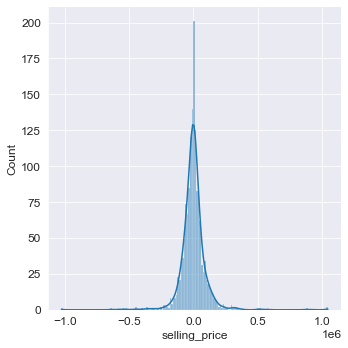

In [23]:
# visualization of error rate in the model

sns.displot(y_test - final_predictions, kde = True);

### Final Pipeline for prediction

In [24]:
# creating a full pipeline to predict the price of a car

from sklearn.pipeline import Pipeline
full_pipeline_with_predictor = Pipeline([
    ('preparation', pipeline),
    ('final_model', final_model)
])
full_pipeline_with_predictor.fit(car_features, car_label)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('std_scaler',
                                                  StandardScaler(),
                                                  ['car_age', 'km_driven',
                                                   'mileage', 'engine',
                                                   'max_power',
                                                   'num_of_seats']),
                                                 ('cat', OneHotEncoder(),
                                                  ['car_company', 'variant',
                                                   'fuel_type', 'seller_type',
                                                   'transmission_type',
                                                   'num_of_ownership'])])),
                ('final_model',
                 RandomForestRegressor(max_features=103, n_estimators=180,
                                       random_state=42))])

In [25]:
model = full_pipeline_with_predictor

In [26]:
# storing the final model as a pkl 

import joblib

joblib.dump(model, 'model.pkl')

['model.pkl']